In [ ]:
%pip install -r "C:\Users\salmaan\projects_github\lending_underwriter\requirements.txt"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set SHAP to use the Matplotlib backend
shap.initjs()

# Import our custom functions from the 'src' package
# This works because we ran 'pip install -e .'
from credi_synth_ai.data import generate_synthetic_data
from credi_synth_ai.train import train_model

In [ ]:
# Generate our sample data
df = generate_synthetic_data(num_rows=2000)
df.head()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    

# Import our custom functions from the 'src' package
# This works because we ran 'pip install -e .'
from credi_synth_ai.data import generate_synthetic_data
from credi_synth_ai.train import train_model

# Generate our sample data
df = generate_synthetic_data(num_rows=2000)
df.head()



# Train the model and get the explainer
# The train function prints the classification report
model_pipeline, X_test, y_test = train_model(df)

Generated 2000 samples.
Default rate: 15.00%
--- RUNNING (NO-SHAP) train_model FUNCTION ---
Model Evaluation Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       340
           1       0.98      0.90      0.94        60

    accuracy                           0.98       400
   macro avg       0.98      0.95      0.96       400
weighted avg       0.98      0.98      0.98       400

Model successfully trained (SHAP was skipped).


Model Feature Importances:
num_cheque_bounces_last_6mo    0.495062
business_vintage_months        0.283686
avg_monthly_gst_turnover       0.099904
avg_monthly_bank_balance       0.085831
industry_type_Manufacturing    0.020357
industry_type_Retail           0.008665
industry_type_Service          0.006494
dtype: float32


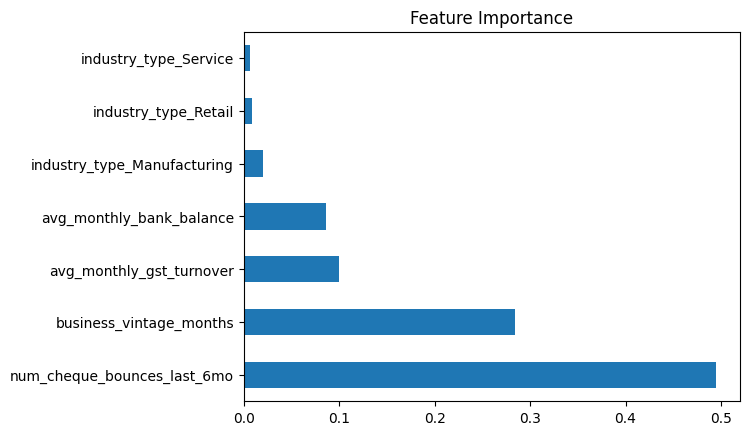

In [2]:
# Get the trained classifier from our pipeline
classifier = model_pipeline.named_steps['classifier']

# Get the feature names from our preprocessor
# This is a bit complex but necessary to match names to data
cat_features_out = model_pipeline.named_steps['preprocessor'] \
                    .named_transformers_['cat'] \
                    .get_feature_names_out()

all_feature_names = model_pipeline.named_steps['preprocessor'] \
                    .named_transformers_['num'].feature_names_in_ \
                    .tolist() + list(cat_features_out)

# Create a simple pandas Series to hold the importance scores
importances = pd.Series(
    classifier.feature_importances_, 
    index=all_feature_names
).sort_values(ascending=False)

# Plot the importances
print("Model Feature Importances:")
print(importances)

importances.plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# --- Global Feature Importance ---
# This plot answers: "What factors does our model care about most?"
print("SHAP Global Feature Importance (Summary Plot)")
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)
plt.title("Key Drivers of Loan Default Risk")
plt.show()

# This plot shows the direction of the impact
print("\nSHAP Feature Impact (Dot Plot)")
shap.summary_plot(shap_values, X_test_processed_df, show=False)
plt.show()

In [ ]:
# --- Individual Decision Plot ---
# This answers: "Why was this specific MSME (e.g., #10) approved/rejected?"

# Let's find a "defaulted" case
defaulted_index = y_test[y_test == 1].index[0]
defaulted_sample = X_test.loc[defaulted_index]

# Get the processed version of this single sample
sample_processed = model_pipeline.named_steps['preprocessor'].transform(defaulted_sample.to_frame().T)

# Get the SHAP values for just this one sample
sample_shap_values = explainer(sample_processed)

print(f"--- Explaining Decision for Business (Index {defaulted_index}) ---")
print("Original Data:")
print(defaulted_sample)

# Show the waterfall plot
# This shows how each feature "pushed" the score from the base value to the final prediction
shap.waterfall_plot(sample_shap_values[0])